#  Food vision Big

## Check out GPU

In [2]:
!nvidia-smi

Wed Sep 13 14:19:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P0              11W /  60W |    581MiB /  4096MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get helper functions 



In [113]:
import helper_functions 

In [4]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [114]:
 (train_data , test_data) , ds_infoe = tfds.load(name="food101",
                                                split=["train","validation"],
                                                shuffle_files=True,
                                                as_supervised=True ,# Data get returns in tuple format (data , label)
                                                with_info=True)

##  Exploring the food100 data from tensorflow Datasets


In [6]:
ds_infoe

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

In [7]:
# Featre of food 101 from tfds 
ds_infoe.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the classs names
class_name = ds_infoe.features['label'].names
class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one smaple  of the train data  
train_one_sample = train_data.take(1)

In [10]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image , label in train_one_sample:
     print(f"""
     Image Shape {image.shape}
     Image datatype: {image.dtype}
     Target class from food101 (tensor form): {label}
     Class name (str form): {class_name[label.numpy()]}
     
     """)


     Image Shape (306, 512, 3)
     Image datatype: <dtype: 'uint8'>
     Target class from food101 (tensor form): 29
     Class name (str form): cup_cakes
     
     


In [13]:
# What are the min and max values of our image tensor
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from tensorflow Datasets

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.imshow(image/255)
plt.title(class_name[label.numpy()])
plt.axis(False)

(-0.5, 511.5, 305.5, -0.5)

In [15]:
samples = train_data.take(6)
samples

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

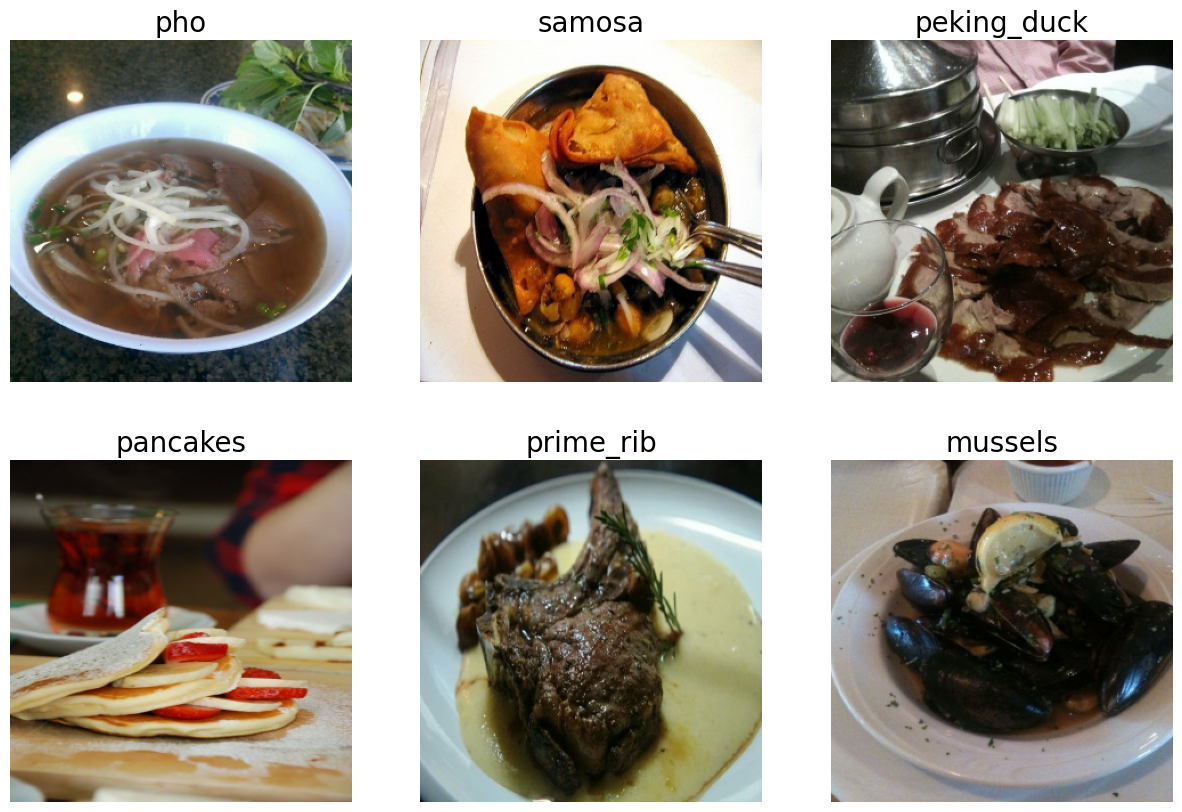

In [16]:

plt.figure(figsize=(15,10))
i =0
for image , labels in samples.as_numpy_iterator():
    plt.subplot(2,3,i+1)
    i = i+1
    image = tf.image.resize(image,(300,300))
    plt.imshow(image/255)
    plt.title(class_name[labels],fontsize=20)
    plt.axis(False)

## Create preprocessing functions for our data
    Neural network perform best when data is in a certain way (e.g batched , normalized , etc).

    However , not all data (including data from Tensorflow Dataset) comes like this .

    so in order to get it readyfor neural network, you'll often have to write peprocessing functions and map it to ypur data,

    What we know about our data:
    * In `uint8` datatype
    * Comprised of all diffrent size tensors (diffrent sized images)
    * Not scaled (the pixel values are between 0 & 255)
    what we know models like:
    * Data in `float32` dtypre (or for mixed precision `float16` and `float32`)
    * For batches, Tensorflow likes all of the tensors within a batch to be of the same size 
    * Scaled (values between 0 & 1) also called normalied tensors generally perform better 

    With these points in mind , we've got a few things we can tackle with a preprocessing functions .

    Sinze we're going to use efficient net  pretrain model from tf.keras.applications we don't rescale our data (these architectures have rescaling built-in ).

    This means our funtion needs to :
    1. Reshape our images to all the same size
    2. Conver the type of our image tensors from `uint8` to `float32`

In [17]:
# Make a function for preprocessing image
def preprocessing_image(image,label,img_shape=224):
    """
    convert image datatype from `uint8` -> 'float32' and reshape 
    image to [img_shape,img_shape , color_channel]
    """
    image = tf.image.resize(image,[img_shape,img_shape]) # reshappe image
    return tf.cast(image,tf.float32) , label # return (float32_image,label) tuple 
    

In [18]:
# Preprocess a single sample image and check the output
preprocessed_img = preprocessing_image (image,label)[0]
print(f"Image before preprocessing :\n{image[:2]}...\nShape: {image.shape},\nDatatype:{image.dtype} ")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing :
[[[142.4085   138.4085   135.4085  ]
  [144.62547  140.62547  137.62547 ]
  [144.71333  139.94667  136.94667 ]
  ...
  [161.05154  151.05154  126.05155 ]
  [160.06     150.06     125.06    ]
  [155.05515  145.05515  118.30484 ]]

 [[148.23334  144.23334  141.23334 ]
  [147.76001  143.76001  140.76001 ]
  [146.69266  142.69266  139.69266 ]
  ...
  [158.12666  147.12666  125.12666 ]
  [158.2436   148.1272   123.476395]
  [155.06667  145.04547  120.10906 ]]]...
Shape: (300, 300, 3),
Datatype:<dtype: 'float32'> 
Image after preprocessing:
[[[143.69531  139.69531  136.69531 ]
  [145.1022   140.77821  137.77821 ]
  [146.43658  141.56754  138.56754 ]
  ...
  [161.33768  150.83466  127.343704]
  [160.16077  150.06474  125.35284 ]
  [155.85355  145.84721  119.65941 ]]

 [[146.87624  142.87624  139.87624 ]
  [146.5045   142.5045   139.5045  ]
  [148.13824  143.89342  140.89342 ]
  ...
  [163.89377  152.89377  131.67412 ]
  [161.58403  150.7971   128.9382  ]
  [159.88

## Batch and prepare images 


In [19]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [20]:
# Make preprocessing function to training (and parallel)
train_data = train_data.map(map_func=preprocessing_image , num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocessing_image , num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data , test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks

In [23]:
# Create a tensorboard callbac
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=2)

## Setup mixed precision training
using `float32` and `float16` in the same time speed up while training . 

In [115]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [116]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build data augmentation layer

In [26]:
from tensorflow.keras import layers

In [27]:
data_aug = tf.keras.Sequential([
    #layers.RandomZoom(0.2),
    #layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2)
],name="Data_Augmentation")

## Build feature extraction model 

In [28]:
input_shape = (2,4,5,3)
x = tf.random.normal(input_shape)
print(f"x : \n {x}")
y = tf.keras.layers.GlobalAveragePooling2D()(x)
y , y.shape

x : 
 [[[[-1.1891385  -0.19763155 -0.10867731]
   [-0.8415429   1.9200317   0.75894785]
   [-0.936696   -2.6235254   0.25053117]
   [-0.2411471   0.35223433  1.1413012 ]
   [-0.01021322 -0.2996065  -1.4219671 ]]

  [[ 0.7403467   2.553755    1.1404366 ]
   [-0.55144936 -0.11942825 -0.23676689]
   [-1.1181676  -0.52857685  0.05943025]
   [-0.12550113  0.5916416   1.1137687 ]
   [-0.6583998   0.00953646  0.59376556]]

  [[ 0.25980434  0.46364877 -0.9718183 ]
   [ 0.66258955  0.11381665 -0.7640757 ]
   [-0.79012513  1.046272    0.9396309 ]
   [-1.3470842   0.4138126  -0.28401035]
   [-1.8275632  -0.22174723 -1.4557915 ]]

  [[-1.581373    1.6009792   0.3055072 ]
   [ 0.37257394 -0.7839762   0.42017546]
   [-1.1543785   0.13372076 -0.88059354]
   [-1.0117565   0.11791816  0.8136958 ]
   [ 0.25629768 -0.03705768 -0.65548056]]]


 [[[ 1.431281    0.05258521  1.6621001 ]
   [-0.07999291 -0.18122171  0.41105554]
   [ 0.70881927  1.4906483  -0.9858412 ]
   [-0.8854187  -0.44917333 -0.8941998 ]


(<tf.Tensor: shape=(2, 3), dtype=float16, numpy=
 array([[-0.5547 ,  0.2253 ,  0.03787],
        [ 0.1526 , -0.1699 , -0.1616 ]], dtype=float16)>,
 TensorShape([2, 3]))

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a model 
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False,input_shape=input_shape)
base_model.trainable=False

inputs = layers.Input(shape=input_shape,name="input_layer")

x = data_aug(inputs)

x = base_model(x , training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_name))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

#compilr the model 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

## Checking layer dtype policies (are we using mixed precision)

In [31]:
for layer in model.layers:
    print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
Data_Augmentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit the feature extraction model  

In [32]:
len(train_data)

2368

In [33]:
history_101_food_classes_feature_extract = model.fit(train_data
          ,steps_per_epoch=len(train_data),
          epochs=3,
          validation_data=test_data,
          validation_steps=0.15 * len(test_data),
          callbacks=[model_checkpoint,
                     create_tensorboard_callback(dir_name="training_logs",experiment_name="efficientnetb0_101_classes_all_data_feature_extract")])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230913-142002
Epoch 1/3


2023-09-13 14:20:07.110187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


   1/2368 [..............................] - ETA: 3:37:51 - loss: 4.8059 - accuracy: 0.0000e+00

2023-09-13 14:20:08.415584: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xbc534a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-13 14:20:08.415606: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-13 14:20:08.419014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 14:20:08.419032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-13 14:20:08.496515: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - ETA: 0s - loss: 1.9803 - accuracy: 0.5213WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 170s 70ms/step - loss: 1.9803 - accuracy: 0.5213 - val_loss: 1.2134 - val_accuracy: 0.6765
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.4845 - accuracy: 0.6196WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 138s 58ms/step - loss: 1.4845 - accuracy: 0.6196 - val_loss: 1.1063 - val_accuracy: 0.7022
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.3628 - accuracy: 0.6472WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 140s 59ms/step - loss: 1.3628 - accuracy: 0.6472 - val_loss: 1.0683 - val_accuracy: 0.7090


In [34]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 37s 47ms/step - loss: 1.0803 - accuracy: 0.7055


[1.0803163051605225, 0.7055445313453674]

## Save weights  Data augmentation model

In [35]:
save_weights_path_data_aug = "food_101_project_feature_extraction_data_aug/"

In [36]:

model.save_weights(save_weights_path_data_aug)

## Load model weights Data augmentation model

In [37]:
model.load_weights(save_weights_path_data_aug)

## Unfreezing some layers 


In [38]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False


In [118]:
for i , layer in enumerate(model.layers[2].layers[-10:]):
    print(i , layer.name , layer.trainable)

0 block7a_se_squeeze True
1 block7a_se_reshape True
2 block7a_se_reduce True
3 block7a_se_expand True
4 block7a_se_excite True
5 block7a_project_conv True
6 block7a_project_bn True
7 top_conv True
8 top_bn True
9 top_activation True


In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])

## Make callbacks

In [41]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=2) # if val loss doesn't decreases for  2 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


In [42]:
fine_tuning_history = model.fit(train_data,
         epochs=12,
         steps_per_epoch=len(train_data),
         validation_data=test_data,
         validation_steps=0.15*len(test_data),
         initial_epoch=2,
         callbacks=[model_checkpoint,early_stopping,reduce_lr])

Epoch 3/12
2368/2368 [==============================] - ETA: 0s - loss: 1.1299 - accuracy: 0.7024INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 193s 78ms/step - loss: 1.1299 - accuracy: 0.7024 - val_loss: 0.8741 - val_accuracy: 0.7566 - lr: 1.0000e-04
Epoch 4/12
2368/2368 [==============================] - ETA: 0s - loss: 0.9258 - accuracy: 0.7509INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 184s 78ms/step - loss: 0.9258 - accuracy: 0.7509 - val_loss: 0.8259 - val_accuracy: 0.7689 - lr: 1.0000e-04
Epoch 5/12
2368/2368 [==============================] - ETA: 0s - loss: 0.7882 - accuracy: 0.7837INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 182s 77ms/step - loss: 0.7882 - accuracy: 0.7837 - val_loss: 0.8163 - val_accuracy: 0.7713 - lr: 1.0000e-04
Epoch 6/12
2368/2368 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.8130INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc278880>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc234d00>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1eebb0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc1a8a60>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc13da90>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc14fb20>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc160b50>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc173be0>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc12da90>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ef940>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0ab7f0>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0b7820>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc04f8b0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc0618e0>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bcc075970>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47eb820>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47a76d0>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4760580>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb47725b0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4706640>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb4719670>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb472d700>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46e7610>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb469f4c0>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4bb46b54f0>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916d20d0>, 139964998691600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916e9490>, 139964998313344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916806d0>, 139964998826480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9168b8e0>, 139964998487296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916a0850>, 139964998487776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b916b2820>, 139964998484656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91645790>, 139964998399440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91657760>, 139964998432304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9166a970>, 139964670862640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915ffb80>, 139964670931856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91610d90>, 139964671007520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91628d00>, 139964671007440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9163acd0>, 139964670864400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915cdc40>, 139964998565936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915e0c10>, 139964670802800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915f4e20>, 139964998805024), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9159d040>, 139964998689488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915b7280>, 139964670608608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b915481f0>, 139964670609168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9155e1c0>, 139964998567056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b9156f130>, 139964670576880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91501100>, 139964670628560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91519310>, 139964670716944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b91531520>, 139964667779632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4b914c4490>, 139964669766640), {}).


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 185s 78ms/step - loss: 0.6666 - accuracy: 0.8130 - val_loss: 0.7883 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 7/12
2367/2368 [============================>.] - ETA: 0s - loss: 0.5656 - accuracy: 0.8394
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 162s 68ms/step - loss: 0.5655 - accuracy: 0.8394 - val_loss: 0.8209 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 8/12
2368/2368 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.8860
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 163s 69ms/step - loss: 0.4009 - accuracy: 0.8860 - val_loss: 0.8199 - val_accuracy: 0.7849 - lr: 2.0000e-05


### With data aug

In [43]:
model.evaluate(test_data)

790/790 [==============================] - 37s 46ms/step - loss: 0.8366 - accuracy: 0.7832


[0.8366205096244812, 0.7832475304603577]

### Load fine tune model checkpoint

In [44]:
model = tf.keras.models.load_model(checkpoint_path)

## Plot loss curves

In [45]:
import pandas as pd
Feature_loss = pd.DataFrame(history_101_food_classes_feature_extract.history)[["loss","val_loss"]]
Feature_loss

Fine_Tune_loss = pd.DataFrame(fine_tuning_history.history)[["loss","val_loss"]]
Fine_Tune_loss

loss  val_loss
0  1.129924  0.874142
1  0.925803  0.825936
2  0.788219  0.816325
3  0.666638  0.788335
4  0.565514  0.820945
5  0.400889  0.819936

In [46]:
import numpy as np
concatenate_loss = np.r_[Feature_loss.to_numpy() , Fine_Tune_loss.to_numpy()]
concatenate_loss

array([[1.98033619, 1.21338701],
       [1.48450685, 1.10632777],
       [1.36277878, 1.06830275],
       [1.12992442, 0.87414199],
       [0.92580283, 0.82593608],
       [0.78821921, 0.81632501],
       [0.66663796, 0.78833479],
       [0.56551421, 0.82094491],
       [0.40088886, 0.8199358 ]])

In [47]:
Feature_acc = pd.DataFrame(history_101_food_classes_feature_extract.history)[["accuracy","val_accuracy"]]
Feature_acc

Fine_Tune_acc = pd.DataFrame(fine_tuning_history.history)[["accuracy","val_accuracy"]]
Fine_Tune_acc

accuracy  val_accuracy
0  0.702429      0.756565
1  0.750944      0.768908
2  0.783657      0.771271
3  0.813003      0.777311
4  0.839419      0.775998
5  0.886046      0.784926

In [48]:
concatenate_acc = np.r_[Feature_acc , Fine_Tune_acc]
concatenate_acc

array([[0.52133334, 0.67647058],
       [0.61963034, 0.7022059 ],
       [0.64723432, 0.70903361],
       [0.70242906, 0.75656515],
       [0.7509439 , 0.76890755],
       [0.78365678, 0.77127099],
       [0.8130033 , 0.77731091],
       [0.83941913, 0.77599788],
       [0.88604623, 0.78492647]])

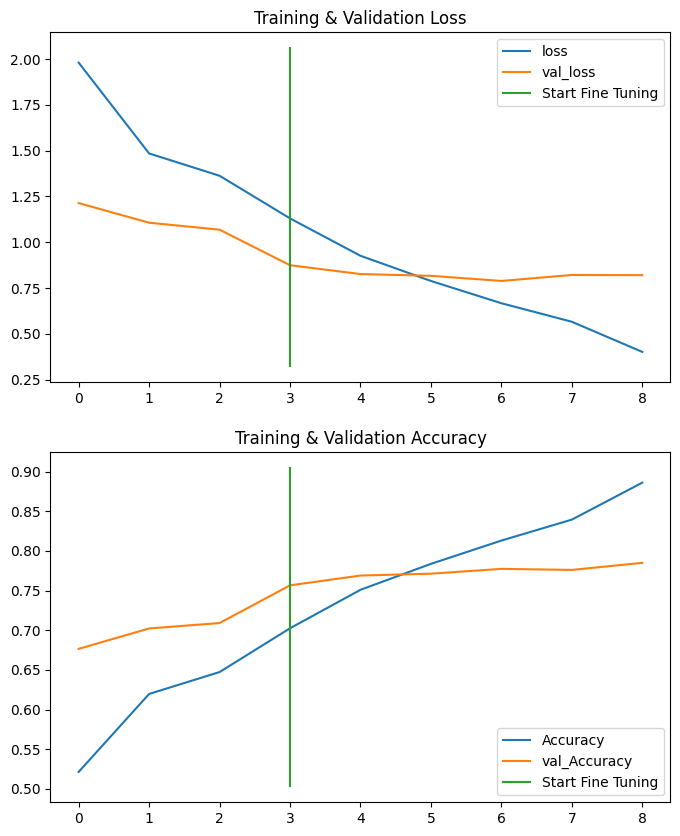

In [49]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(concatenate_loss,label=["loss","val_loss"])
plt.plot([3, 3],plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
plt.title("Training & Validation Loss")
plt.legend()
plt.subplot(2,1,2)
plt.plot(concatenate_acc,label=["Accuracy","val_Accuracy"])
plt.plot([3, 3],plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
plt.title("Training & Validation Accuracy")
plt.legend(loc="lower right")

## Visualizing predictions on test images
 

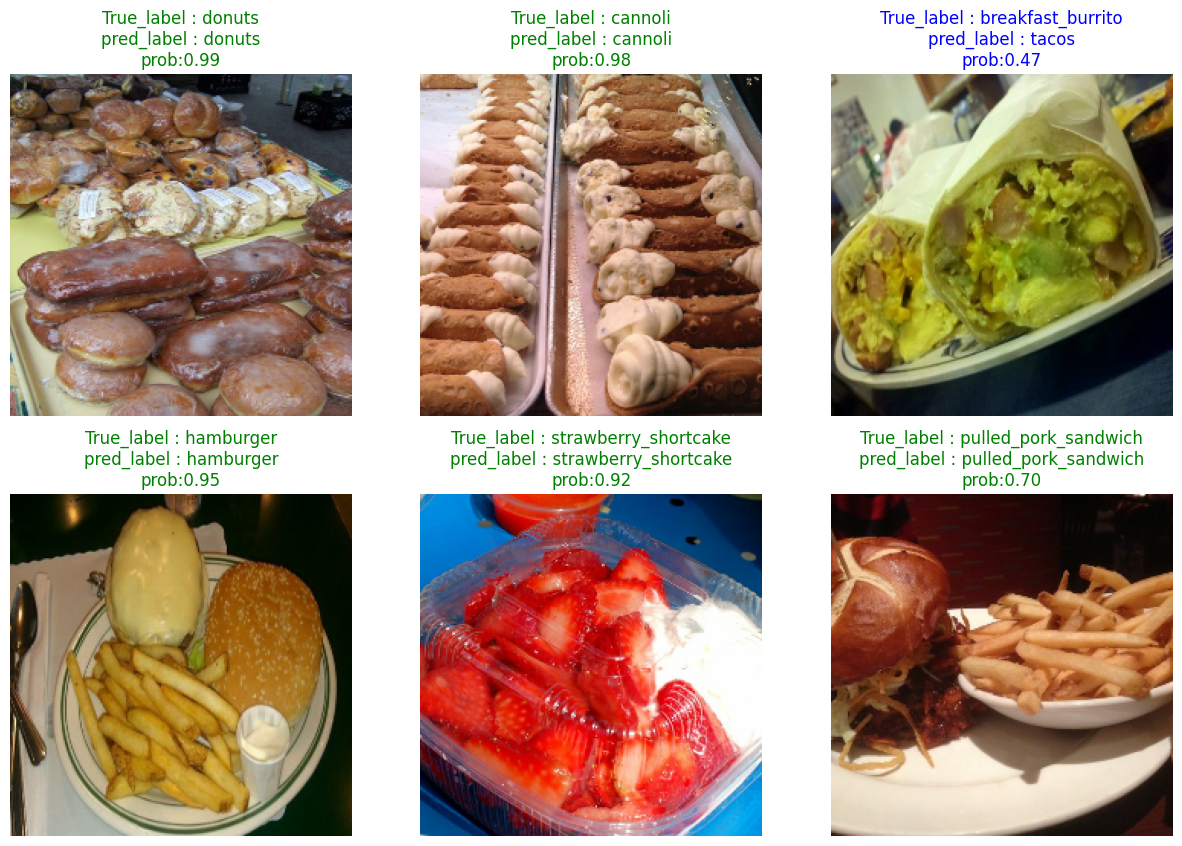

In [95]:
samples = train_data.unbatch()
samples = samples.take(6)

plt.figure(figsize=(15,10))
i=0
for image , labels in samples:
    plt.subplot(2,3,i+1)
    
#     print(image.shape)
    image = tf.image.resize(image,(224,224))
    
    expand_image = tf.expand_dims(image,axis=0)
    y_pred_prob = model.predict(expand_image,verbose=0)
    prob = np.max(y_pred_prob)
#     print(prob)
#     print(y_pred_prob.shape)
    y_pred = tf.argmax(y_pred_prob,axis=1)
#     print(y_pred)
    print
    if class_name[int(labels)] == class_name[int(y_pred)]: # if prediction True set color to Green else set color to Blue
        c="g"
    else:
        c="b"    

    plt.title(f"True_label : {class_name[int(labels)]}\npred_label : {class_name[int(y_pred)]}\nprob:{prob:.2f}",c=c)
    plt.axis(False)
    plt.imshow(image/255);
    i = i+1

## Make confusion Matrix

In [110]:
y_prod = model.predict(test_data)
y_pred = tf.argmax(y_prod,axis=1)
y_pred

790/790 [==============================] - 35s 44ms/step


<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([65, 70, 34, ..., 36, 34, 39])>

In [104]:
labels = [y for x , y in test_data.unbatch()]
True_label = [int(x) for x in labels]

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cm = confusion_matrix(True_label,y_pred)
cm_norm = cm / cm.sum(axis=1)
plt.figure(figsize=(110,110))
sb.heatmap(cm_norm,annot=True,cmap="summer",xticklabels=class_name,yticklabels=class_name)
plt.xlabel("Predict Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Confusion Matrix')